# Project 1B

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression, HuberRegressor

## 1. Load Data

In [2]:
df_train = pd.read_csv("train.csv")
df_train

,Id,y,x1,x2,x3,x4,x5
0,0,-6.822679,0.02,0.05,-0.09,-0.43,-0.08
1,1,-6.326290,-0.13,0.11,-0.08,-0.29,-0.03
2,2,-9.302728,0.08,0.06,-0.07,-0.41,-0.03
3,3,-7.371893,0.02,-0.12,0.01,-0.43,-0.02
4,4,-6.027647,-0.14,-0.12,-0.08,-0.02,-0.08
...,...,...,...,...,...,...,...
695,695,-6.147394,0.31,-0.09,0.04,-0.09,0.03
696,696,-6.214899,-0.26,-0.01,0.02,-0.40,0.05
697,697,-6.841341,-0.27,-0.22,-0.01,-0.32,-0.05
698,698,-6.523371,0.19,0.11,-0.05,-0.27,-0.04


## 2. Create feature map

In [36]:
def map_to_feature(X, feature_map, max_n):
    Phi = np.stack([feature_map(X, n) for n in range(max_n)], axis=1)
    return Phi

In [37]:
feature_map_list = [
    lambda X, n: X.iloc[:,n],
    lambda X, n: X.iloc[:,n]**2,
    lambda X, n: np.exp(X.iloc[:,n]),
    lambda X, n: np.cos(X.iloc[:,n]),
    lambda X, n: np.ones(X.iloc[:,n].shape)
]
feature_len_list = [5, 5, 5, 5, 1]

In [38]:
wt_list = list()
X = df_train.iloc[:,2:]
y = df_train.iloc[:,1]
Phi = np.concatenate([map_to_feature(X, feature_map_list[i], feature_len_list[i]) for i in range(len(feature_len_list))], axis=1)

## 3. Checking conditioning

It turns out the problem is very ill-conditioned and close to being singular. Therefore, regularization is desired.

In [41]:
np.linalg.cond(Phi.T @ Phi)

407714829257.6802

## 4. Regularized regression

In [91]:
alphas = np.logspace(-1, 2, num=31)

predictor = RidgeCV(alphas=alphas, cv=10, fit_intercept=False).fit(Phi, y)

rms_err = np.sqrt(np.mean((y - predictor.predict(Phi))**2))

print("RMS-error:  {}".format(rms_err))
print("condition:  {}".format(np.linalg.cond(Phi.T @ Phi + alpha * np.identity(Phi.shape[1]))))
print("Reg choice: {}".format(predictor.alpha_))
print(predictor.coef_)

RMS-error:  1.9540678401397567
condition:  710267.0714755888
Reg choice: 39.810717055349734
[ 0.06463819 -0.09935624 -0.14821316  0.1966039   0.05577883 -0.05257226
  0.01796294  0.02632358 -0.08163859  0.00347901 -0.55857682 -0.68766191
 -0.73288575 -0.43722741 -0.53983591 -0.57036329 -0.60540971 -0.60956463
 -0.55629686 -0.598057   -0.59648899]


In [92]:
predictor = HuberRegressor(alpha=predictor.alpha_, max_iter=100, fit_intercept=False).fit(Phi, y)
rms_err = np.sqrt(np.mean((y - predictor.predict(Phi))**2))

print("RMS-error:  {}".format(rms_err))
print(predictor.coef_)

RMS-error:  1.955551724189846
[ 0.0339104  -0.04434283 -0.06600325  0.16371645  0.03069424 -0.02677527
  0.00621715  0.00946419 -0.07182036  0.00144496 -0.58156505 -0.64333881
 -0.66356972 -0.47072449 -0.57077245 -0.58838735 -0.60477479 -0.60640232
 -0.56630247 -0.60232667 -0.60170384]


In [93]:
with open("./results_Ridge-CV10-Huber.csv", 'w') as fwrite:
    for ci in predictor.coef_:
        print(ci, file=fwrite)

In [82]:
np.max(np.abs(y - predictor.predict(Phi)))

7.68589524559616

<AxesSubplot:xlabel='y', ylabel='Count'>

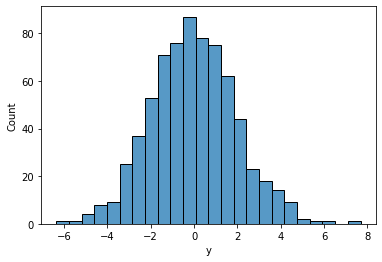

In [84]:
sns.histplot(y - predictor.predict(Phi))